C:\Users\adnan\anaconda3\envs\my_deeplearning_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1641221/1641221 [==============================] - 170s 104us/step
Accuracy: 0.8371
F1 Score: 0.8372
Precision: 0.8366
Recall: 0.8378

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84     12500
           1       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



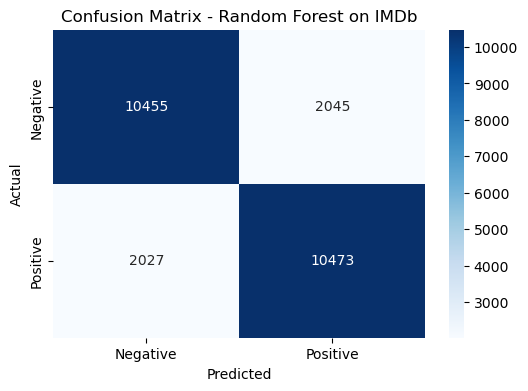

In [1]:
# Install required packages if not already installed
# !pip install scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
# ---------------------------
# 1. Load IMDb dataset
# ---------------------------
# sklearn has a fetch function, but IMDb large dataset is big.
# Here we use the small dataset from keras for example purposes.


# Parameters
num_words = 5000  # Use top 5000 words
maxlen = 500      # Max review length

# Load dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

# Convert sequences to same length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# ---------------------------
# 2. Convert numeric sequences to strings for TF-IDF
# ---------------------------
word_index = imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}  # shift by 3 for reserved indices
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

def decode_review(seq):
    return " ".join([index_word.get(i, "?") for i in seq])

X_train_text = [decode_review(seq) for seq in X_train]
X_test_text = [decode_review(seq) for seq in X_test]

# ---------------------------
# 3. Vectorize text using TF-IDF
# ---------------------------
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# ---------------------------
# 4. Train Random Forest
# ---------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# ---------------------------
# 5. Predictions
# ---------------------------
y_pred = rf.predict(X_test_tfidf)

# ---------------------------
# 6. Evaluation
# ---------------------------
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------------------
# 7. Confusion Matrix Plot
# ---------------------------
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest on IMDb')
plt.show()

In [4]:
from flask import Flask, request, jsonify, render_template
import pickle
import numpy as np

app = Flask(__name__)

# Load model and vectorizer (make sure these files exist)
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# (Optional) precomputed evaluation metrics and confusion matrix to show on front-end
# You can compute these during training and save them, here we hardcode example values
GLOBAL_METRICS = {
    "accuracy": 0.88,
    "precision": 0.89,
    "recall": 0.87,
    "f1": 0.88
}
GLOBAL_CONFUSION = [[450, 50], [60, 440]]  # example

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    review = data.get('review', '')
    if not review:
        return jsonify({'error': 'No review provided'}), 400

    # Vectorize and predict
    X = vectorizer.transform([review])
    pred_proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[0]
        # assume binary classes [neg, pos] where pos is index 1
        pos_prob = float(proba[1])
        pred_proba = pos_prob
    pred_label = model.predict(X)[0]
    label_text = 'Positive' if int(pred_label) == 1 else 'Negative'

    return jsonify({
        "prediction": label_text,
        "probability": pred_proba,
        "metrics": GLOBAL_METRICS,
        "confusion": GLOBAL_CONFUSION
    })

if __name__ == '__main__':
    app.run(debug=True)
#How to wire everything up (short steps)
#Put index.html into templates/ folder (Flask default).

ModuleNotFoundError: No module named 'flask'

In [ ]:
# Next cell: save the fitted vectorizer + model as a single pipeline and show manifest
# Requires: joblib, sklearn (already in your env if you ran previous cell)

from sklearn.pipeline import Pipeline
import joblib
import os
import pandas as pd

# ASSUMPTION: `vectorizer` and `rf` are already defined & fitted in the previous cell
# If you re-ran training in the previous cell, this will work directly.

# Create a Pipeline that uses the fitted transformer + fitted estimator
pipeline = Pipeline([('tfidf', vectorizer), ('rf', rf)])

# Save path
out_path = "/mnt/data/imdb_tfidf_rf_pipeline.joblib"

# Save the entire pipeline
joblib.dump(pipeline, out_path, compress=3)  # compress optional

# Verify saved file exists and size
size = os.path.getsize(out_path)
print(f"Saved pipeline to: {out_path}")
print(f"File size: {size} bytes")

# Quick load & sanity-check predictions
loaded = joblib.load(out_path)
samples = [
    "This movie was fantastic! I loved the acting and story.",
    "I hated this film. It was boring and too long."
]
preds = loaded.predict(samples)
for s, p in zip(samples, preds):
    print(f"\nText: {s}\nPredicted label: {p}  (0=negative, 1=positive)")

# Produce a small manifest dataframe so you can see the file info in the notebook UI
manifest = pd.DataFrame([{"file": out_path, "type": "sklearn_pipeline_joblib", "size_bytes": size}])
display(manifest)  # Jupyter will render this nicely
